<a href="https://colab.research.google.com/github/componavt/differential_equations/blob/main/src/hill_equation/6_numerical_solvers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧮 Hill Equation Solver Benchmark

- Target: Solve stiff $\frac{dx}{dt}=f(x,\alpha)$  
- Range: $\alpha=10^{-2}$ to $10^{-5}$  
- Methods:  
  - ⏩ RK45 (explicit)  
  - ⏳ BDF (implicit)  
  - 🏗️ Radau (implicit)  
- Metric: Success rate at different α

# 🔢 Numerical Solvers for Stiff Hill-Type ODE

- **Equation**:  
  $\frac{dx}{dt} = \frac{x^{1/\alpha}}{b^{1/\alpha} + x^{1/\alpha}}$  
  - $x(0) ≈ b = 1.0$  
  - $\alpha \in [10^{-5}, 10^{-2}]$ (stiffness regime)

- **Solvers**:  
  - 🚀 `RK45` - adaptive step size  
  - 🛡️ `BDF` - stiff equations specialist  
  - 💎 `Radau` - implicit stability  

- **Features**:  
  - Log-spaced $\alpha$ values  
  - Automatic error handling  
  - Comparative visualization

In [20]:
# Parameters
b = 1.0
x0 = b * 0.99999  # Initial condition x(0) ≈ b
nonuniformity_power = 3.0  # Controls how dense the points are near t = 1 (higher = denser)


# Cell 1: Parameters and library imports
b = 1.0
x0 = b * 0.99999  # Initial condition x(0) ≈ b
nonuniformity_power = 3.0  # Controls how dense the points are near t = 1 (higher = denser)

!pip install deepxde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pickle


# Define Hill-type equation generator (DeepXDE neural network version)
#def get_hill_equation(alpha):
#  def hill_equation(x, y):
#     y_safe = tf.clip_by_value(y, 1e-6, 1e6)
#     dy_t = dde.grad.jacobian(y, x, i=0, j=0) # dy/dt
#     x_alpha = tf.pow(y_safe, 1 / alpha)      # x^(1/alpha)
#     b_alpha = tf.pow(b, 1 / alpha)           # b^(1/alpha)
#     return dy_t - x_alpha / (b_alpha + x_alpha)
#  return hill_equation


# Define Hill-type equation RHS (NumPy version)
def get_rhs(alpha, method_name, error_log):
    def rhs(t, x):
        x_safe = np.clip(x[0], 1e-6, 1e6)
        inv_alpha = 1 / alpha
        try:
            log_x = np.log(x_safe)
            log_b = np.log(b)
            x_alpha = np.exp(log_x * inv_alpha)
            b_alpha = np.exp(log_b * inv_alpha)
            denom = b_alpha + x_alpha
            if np.isinf(denom) or np.isnan(denom):
                raise ValueError("Denominator became NaN or Inf")
            return [x_alpha / denom]
        except Exception as e:
            msg = f"Numerical error in {method_name} at t={t:.5f}, x={x_safe:.5f}, alpha={alpha:.2e}: {e}"
            print(msg)
            error_log[method_name] += 1
            return [0.0]
    return rhs

# Alpha range with potential small values (log-spaced)
#alpha = 0.01
#alpha_list = np.logspace(-2, -5, 10)  # от 0.01 до 0.00001 логарифмически
alpha_list = np.logspace(-2, -5, 3)  # от 0.01 до 0.00001 логарифмически
#alpha_list = np.logspace(-3, -7, 10)  # от 0.001 до 0.0000001: 2.78e-07 ok, 1.0e-07 NaN
#alpha_list = np.logspace(-5, -7, 10)  # от 0.00001 до 0.0000001
#alpha_list = np.logspace(-5, -6.11, 10)  # from 1e-5 to ~1.3e-6 # ok for NeuralNetwork
#alpha_list = np.logspace(-4, -9, 20)  # от 0.0001 до 0.000000001 логарифмически - много NaN

print("Alpha values:", alpha_list)

Alpha values: [1.00000000e-02 3.16227766e-04 1.00000000e-05]


In [21]:
# Cell 2: Numerical solution with SciPy solvers

# Evaluation time points (uniform)
N = 10 # 500
t_eval = np.linspace(0, 1, N)

# Solve and store results for all alpha values
all_results = {"combined": []}
error_counts = {"RK45": 0, "BDF": 0, "Radau": 0}
fail_counts = {"RK45": 0, "BDF": 0, "Radau": 0}

total = len(alpha_list)
for index, alpha in enumerate(alpha_list):
    progress_percent = int((index + 1) / total * 100)
    print(f"[{progress_percent:3d}%] Solving for alpha = {alpha:.2e} ({index + 1}/{total})")

    alpha_label = f"α={alpha:.1e}"
    all_results[alpha_label] = []

    for method in ["RK45", "BDF", "Radau"]:
        rhs = get_rhs(alpha, method, error_counts)
        try:
            sol = solve_ivp(rhs, [0, 1], [x0], t_eval=t_eval, method=method)
            all_results[alpha_label].append((sol.t, sol.y[0], method))
            all_results["combined"].append((sol.t, sol.y[0], method, alpha_label))
        except Exception as e:
            print(f"{method} failed for alpha={alpha:.2e}: {e}")
            fail_counts[method] += 1

# Save to file
with open("solvers_results.pkl", "wb") as f:
    pickle.dump(all_results, f)

print("\n=== Summary of failures ===")
for method in ["RK45", "BDF", "Radau"]:
    print(f"{method} failed {fail_counts[method]} times out of {total}")
    print(f"{method} numerical errors: {error_counts[method]} times")

[ 33%] Solving for alpha = 1.00e-02 (1/3)
[ 66%] Solving for alpha = 3.16e-04 (2/3)
Numerical error in RK45 at t=0.27834, x=1.28595, alpha=3.16e-04: Denominator became NaN or Inf
Numerical error in RK45 at t=0.35847, x=1.36608, alpha=3.16e-04: Denominator became NaN or Inf
Numerical error in RK45 at t=0.38619, x=1.48449, alpha=3.16e-04: Denominator became NaN or Inf
Numerical error in RK45 at t=0.42084, x=1.42693, alpha=3.16e-04: Denominator became NaN or Inf
Numerical error in RK45 at t=0.42084, x=1.28512, alpha=3.16e-04: Denominator became NaN or Inf
Numerical error in RK45 at t=0.48058, x=1.28512, alpha=3.16e-04: Denominator became NaN or Inf
Numerical error in RK45 at t=0.51045, x=1.28512, alpha=3.16e-04: Denominator became NaN or Inf
Numerical error in RK45 at t=0.65980, x=1.28512, alpha=3.16e-04: Denominator became NaN or Inf
Numerical error in RK45 at t=0.68635, x=1.28512, alpha=3.16e-04: Denominator became NaN or Inf
Numerical error in RK45 at t=0.71954, x=1.28512, alpha=3.16e-

/tmp/ipython-input-20-2672437659.py:38: RuntimeWarning: overflow encountered in exp
  x_alpha = np.exp(log_x * inv_alpha)


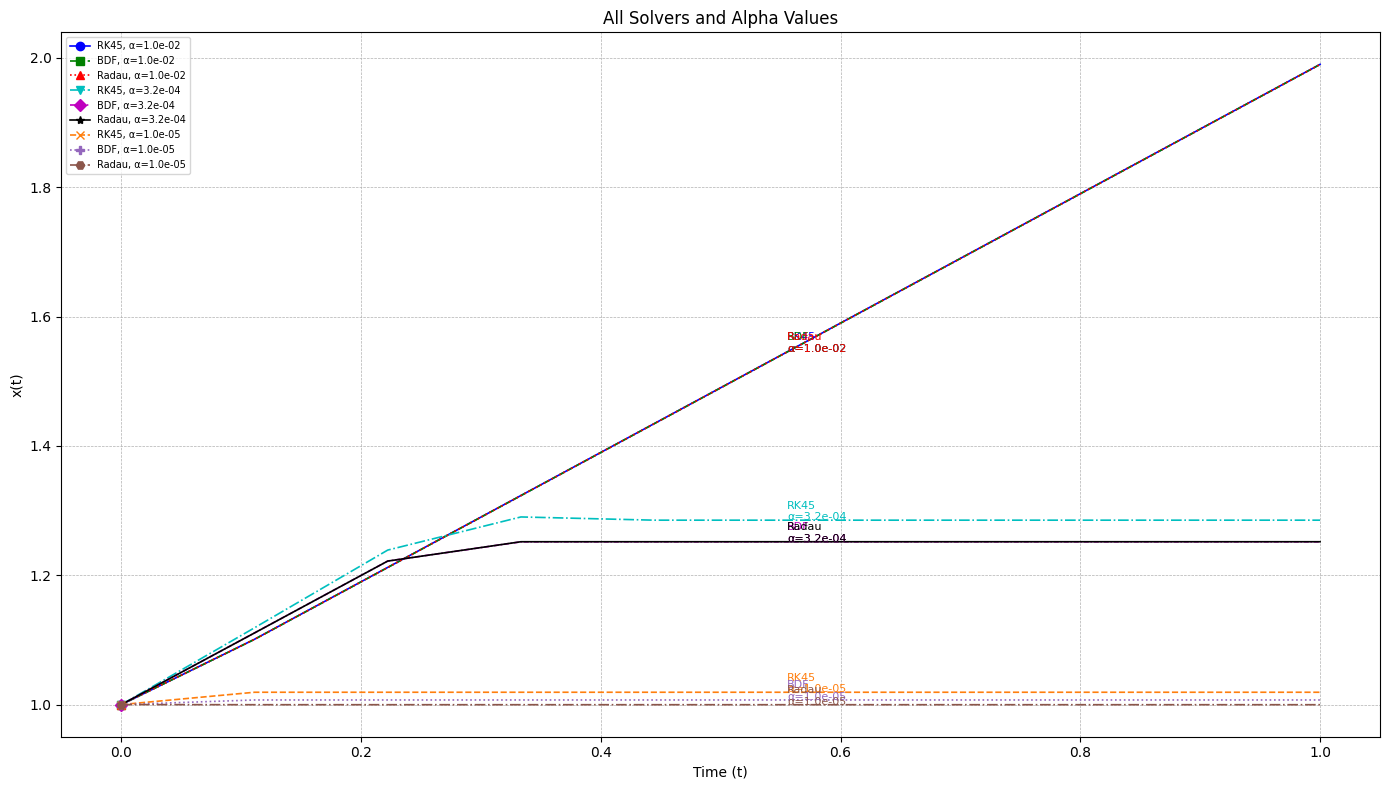

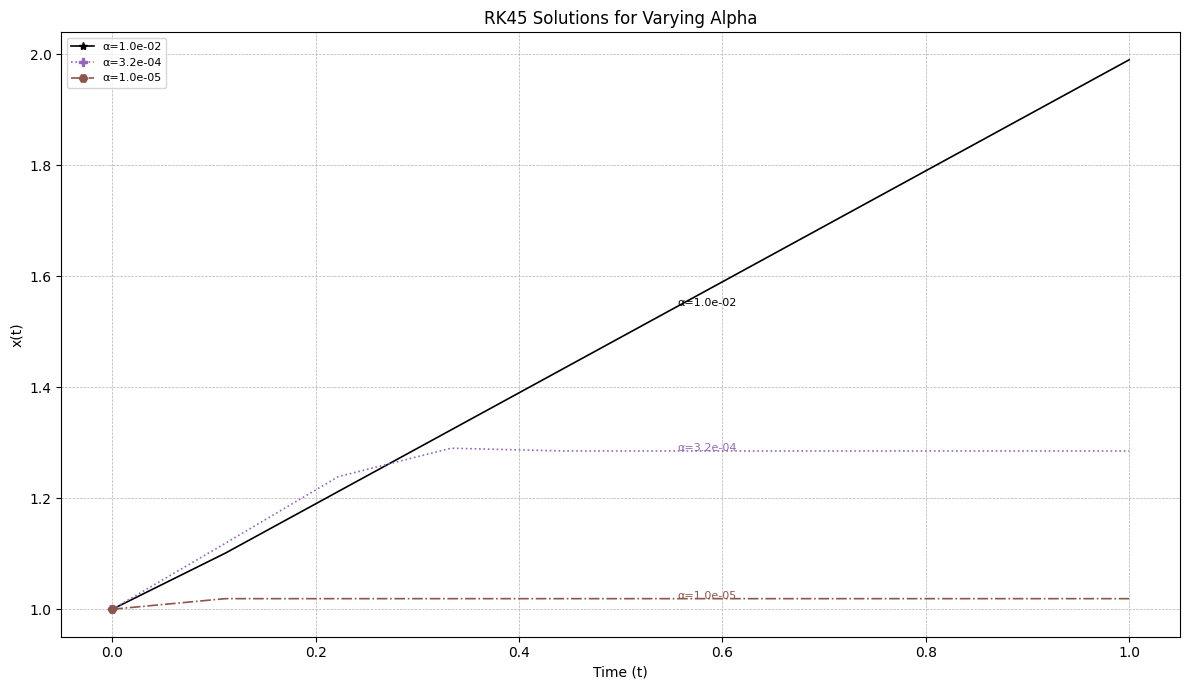

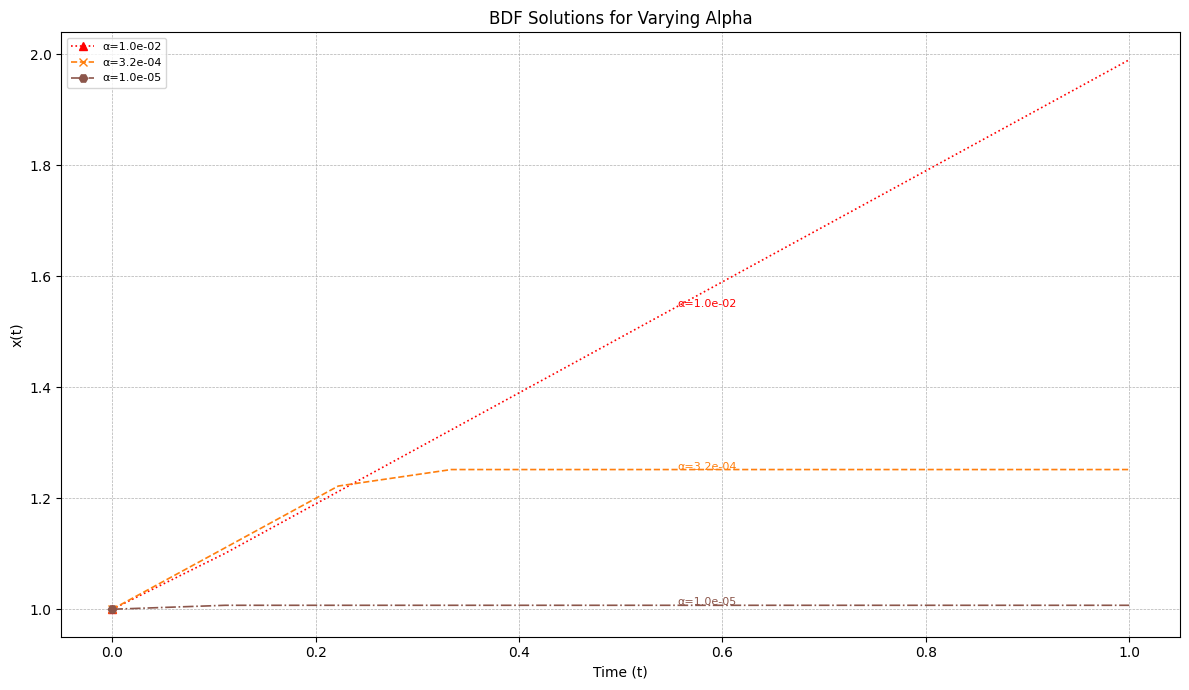

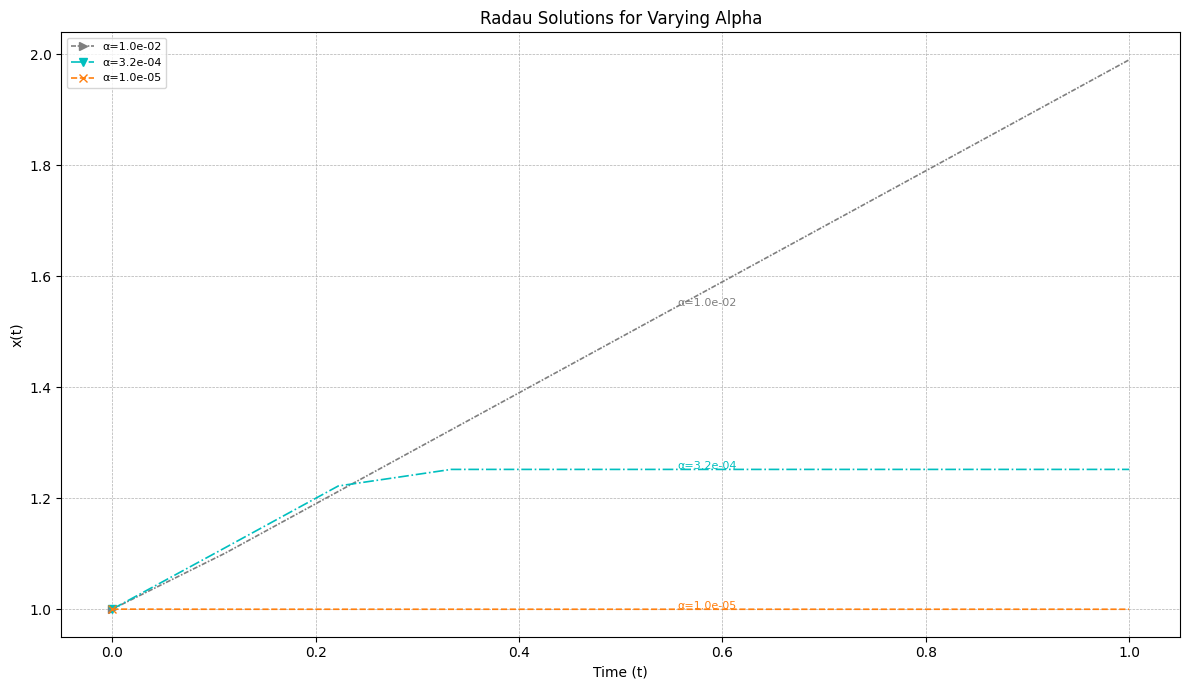

In [22]:
# Cell 3: Visualization block
import matplotlib.pyplot as plt
import pickle

# Load results
with open("solvers_results.pkl", "rb") as f:
    results = pickle.load(f)

# Styling
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]
markers = ['o', 's', '^', 'v', 'D', '*', 'x', 'P', 'H', '>']
colors = ['b', 'g', 'r', 'c', 'm', 'k', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:gray']

# --- Combined plot for all solvers and alpha values ---
plt.figure(figsize=(14, 8))
for i, (t, x, method, alpha_label) in enumerate(all_results["combined"]):
    color = colors[i % len(colors)]
    marker = markers[i % len(markers)]
    linestyle = linestyles[i % len(linestyles)]
    label = f"{method}, {alpha_label}"
    plt.plot(t, x,
             linestyle=linestyle,
             color=color,
             marker=marker,
             markevery=30,
             label=label,
             linewidth=1.2)
    # Annotate on curve
    idx = len(t) // 2
    plt.text(t[idx], x[idx], f"{method}\n{alpha_label}", fontsize=8, color=color)

plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("All Solvers and Alpha Values")
plt.legend(fontsize=7)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- Separate plots for each solver ---
methods = ["RK45", "BDF", "Radau"]
for method in methods:
    plt.figure(figsize=(12, 7))
    for alpha_label, results in all_results.items():
        if alpha_label == "combined":
            continue
        for (t, x, label) in results:
            if label == method:
                i = hash((alpha_label, method)) % len(colors)
                color = colors[i % len(colors)]
                marker = markers[i % len(markers)]
                linestyle = linestyles[i % len(linestyles)]
                plt.plot(t, x,
                         linestyle=linestyle,
                         color=color,
                         marker=marker,
                         markevery=30,
                         label=f"{alpha_label}",
                         linewidth=1.2)
                idx = len(t) // 2
                plt.text(t[idx], x[idx], alpha_label, fontsize=8, color=color)
    plt.xlabel("Time (t)")
    plt.ylabel("x(t)")
    plt.title(f"{method} Solutions for Varying Alpha")
    plt.legend(fontsize=8)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()